[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Dataset size: 44903 articles
Class distribution:
 label
1    23486
0    21417
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Model not found. Training from scratch...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: primus01012000 (primus01012000-unom) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1
1,0.131500,0.226210,0.950688
2,0.050200,0.151285,0.969158
3,0.011700,0.149184,0.972281



Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.98      0.97      4284
        Fake       0.98      0.97      0.97      4697

    accuracy                           0.97      8981
   macro avg       0.97      0.97      0.97      8981
weighted avg       0.97      0.97      0.97      8981



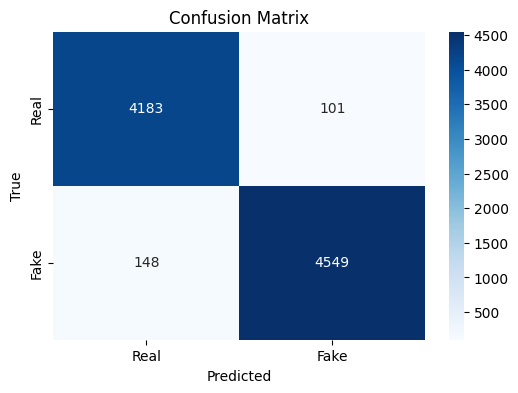


Testing Headlines with DistilBERT:
Headline: Rising Mortgage Rates and Recession Fears Stall a Fragile Housing Market
Prediction: Real

Headline: Real Madrid Announce Trent Alexander-Arnold Signing from Liverpool
Prediction: Real

Headline: Barcelona Sporting Director Deco Says Club Won’t Need to Sell Players This Summer
Prediction: Real

Headline: How Real Is the India-Pakistan Nuclear War Threat?
Prediction: Real

Headline: Coinbase Data Breach Tied to India-Based Outsourcing Partner TaskUs
Prediction: Real

Headline: Mass Jailbreak in Karachi After Earthquake at Malir Jail
Prediction: Real

Headline: Elon Musk Announces Plan to Colonize Mars by 2026
Prediction: Fake

Headline: Secret Government Lab Discovers Time Travel Device
Prediction: Real

Headline: Scientists Discover New Species in Pacific Ocean
Prediction: Real

Headline: Biden Announces New Climate Policy in 2025
Prediction: Real

Headline: Aliens Invade New York with UFOs
Prediction: Fake

Headline: Secret Vaccine Causes 

In [1]:

# Install transformers
!pip install transformers

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
from transformers.trainer_utils import EvalPrediction
from sklearn.metrics import f1_score

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Load and combine dataset
true_file = '/content/True.csv'
fake_file = '/content/Fake.csv'
if not (os.path.exists(true_file) and os.path.exists(fake_file)):
    print("Error: True.csv and/or Fake.csv not found in /content/.")
    raise FileNotFoundError("True.csv and Fake.csv must be in /content/.")

true_data = pd.read_csv(true_file)
fake_data = pd.read_csv(fake_file)
true_data['label'] = 0
fake_data['label'] = 1
data = pd.concat([true_data[['title', 'label']], fake_data[['title', 'label']]], ignore_index=True)

# Add synthetic fake titles
synthetic_fake_titles = pd.DataFrame({
    'title': [
        "Elon Musk Builds Moon Base by 2027",
        "SpaceX Discovers Alien Life on Mars",
        "Tesla CEO Announces Interstellar Travel by 2028",
        "NASA Hides Martian City Found by Musk",
        "Elon Musk’s Hyperloop Connects Earth to Mars"
    ],
    'label': [1] * 5
})
data = pd.concat([data, synthetic_fake_titles], ignore_index=True)

print(f"Dataset size: {len(data)} articles")
print("Class distribution:\n", data['label'].value_counts())

# Preprocess text
def clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['cleaned_text'] = data['title'].apply(clean_text)

# Prepare dataset for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = tokenizer(text, return_tensors='pt', max_length=128, padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Split data
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])
train_dataset = NewsDataset(X_train.tolist(), y_train.tolist())
test_dataset = NewsDataset(X_test.tolist(), y_test.tolist())

# Load existing trained model
model_path = '/content/distilbert_fake_news_model_titles'
if os.path.exists(model_path):
    print(f"Loading trained model from {model_path}")
    model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=2)
else:
    print("Model not found. Training from scratch...")
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Compute metrics
def compute_metrics(eval_pred: EvalPrediction):
    predictions = eval_pred.predictions.argmax(axis=1)
    labels = eval_pred.label_ids
    f1 = f1_score(labels, predictions, average='weighted')
    return {'f1': f1}

# Training arguments
training_args = TrainingArguments(
    output_dir='./results_titles_finetune',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    logging_dir='./logs_titles_finetune',
    logging_steps=100,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tune
trainer.train()

# Evaluate
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Predict new headlines
def predict_news_distilbert(article_text):
    cleaned_article = clean_text(article_text)
    encoding = tokenizer(cleaned_article, return_tensors='pt', max_length=128, padding='max_length', truncation=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    encoding = {k: v.to(device) for k, v in encoding.items()}
    with torch.no_grad():
        outputs = model(**encoding)
    prediction = outputs.logits.argmax().item()
    return 'Fake' if prediction == 1 else 'Real'

# Test headlines with Real/Fake labels
headlines = [
    "Rising Mortgage Rates and Recession Fears Stall a Fragile Housing Market",  # Real
    "Real Madrid Announce Trent Alexander-Arnold Signing from Liverpool",  # Real
    "Barcelona Sporting Director Deco Says Club Won’t Need to Sell Players This Summer",  # Real
    "How Real Is the India-Pakistan Nuclear War Threat?",  # Real
    "Coinbase Data Breach Tied to India-Based Outsourcing Partner TaskUs",  # Real
    "Mass Jailbreak in Karachi After Earthquake at Malir Jail",  # Real
    "Elon Musk Announces Plan to Colonize Mars by 2026",  # Fake
    "Secret Government Lab Discovers Time Travel Device",  # Fake
    "Scientists Discover New Species in Pacific Ocean",  # Real
    "Biden Announces New Climate Policy in 2025",  # Real
    "Aliens Invade New York with UFOs",  # Fake
    "Secret Vaccine Causes Superpowers in Children"  # Fake
]

print("\nTesting Headlines with DistilBERT:")
for headline in headlines:
    prediction = predict_news_distilbert(headline)
    print(f"Headline: {headline}\nPrediction: {prediction}\n")

# Save fine-tuned model
model.save_pretrained('/content/distilbert_fake_news_model_titles_finetuned')
tokenizer.save_pretrained('/content/distilbert_fake_news_tokenizer_titles_finetuned')
print("Model saved to /content/distilbert_fake_news_model_titles_finetuned")


In [2]:
# Test headlines
headlines = [
    "‘Trump picked up the phone and said…’: In Bhopal, Rahul Gandhi’s ‘surrender’ jibe at PM Modi",# Real
    "‘Won’t release Thug Life in Karnataka until dialogue with KFCC’: Kamal Haasan to High Court",# Real
    "India’s Russian arms purchases ‘rubbed US the wrong way’; bilateral trade deal close: Lutnick",# Real
    "Why a seat for Shukla on Axiom-4 is a big moment for India’s space programme",# Real
    "Dozens reported killed as Israel acknowledges troops opened fire near Gaza food point",# Real
    "Run For Their Lives, the group targeted in the Colorado attack, is figuring out how to continue its mission",# Real
    "Government Announces Free Flying Cars for All Citizens by 2028", # Fake
    "Dinosaurs to Be Cloned and Released in New Jurassic National Park" # Fake
]

print("\nTesting Headlines with DistilBERT:")
for headline in headlines:
    prediction = predict_news_distilbert(headline)
    print(f"Headline: {headline}\nPrediction: {prediction}\n")


Testing Headlines with DistilBERT:
Headline: ‘Trump picked up the phone and said…’: In Bhopal, Rahul Gandhi’s ‘surrender’ jibe at PM Modi
Prediction: Fake

Headline: ‘Won’t release Thug Life in Karnataka until dialogue with KFCC’: Kamal Haasan to High Court
Prediction: Fake

Headline: India’s Russian arms purchases ‘rubbed US the wrong way’; bilateral trade deal close: Lutnick
Prediction: Real

Headline: Why a seat for Shukla on Axiom-4 is a big moment for India’s space programme
Prediction: Real

Headline: Dozens reported killed as Israel acknowledges troops opened fire near Gaza food point
Prediction: Real

Headline: Run For Their Lives, the group targeted in the Colorado attack, is figuring out how to continue its mission
Prediction: Fake

Headline: Government Announces Free Flying Cars for All Citizens by 2028
Prediction: Fake

Headline: Dinosaurs to Be Cloned and Released in New Jurassic National Park
Prediction: Fake



In [3]:
# Test headlines
headlines = [
    "Japan’s Nikkei Hits Record High as Tech Stocks Surge in 2025",  # Real
    "Greta Thunberg Leads Global Climate Strike Ahead of UN Summit",  # Real
    "NASA’s Artemis Program Delays Moon Landing to 2027",  # Real
    "Bollywood Star Aamir Khan Announces New Film on India’s Space Race",  # Real
    "Secret AI Develops Human-Level Intelligence in Hidden Lab",  # Fake
    "Elon Musk Unveils Teleportation Device for Public Use by 2029",  # Fake
    "Ancient Pyramid Discovered Under Antarctic Ice",  # Fake
    "World Leaders Sign Pact to Colonize Jupiter by 2030"  # Fake
]

print("\nTesting Headlines with DistilBERT:")
for headline in headlines:
    prediction = predict_news_distilbert(headline)
    print(f"Headline: {headline}\nPrediction: {prediction}\n")


Testing Headlines with DistilBERT:
Headline: Japan’s Nikkei Hits Record High as Tech Stocks Surge in 2025
Prediction: Real

Headline: Greta Thunberg Leads Global Climate Strike Ahead of UN Summit
Prediction: Real

Headline: NASA’s Artemis Program Delays Moon Landing to 2027
Prediction: Real

Headline: Bollywood Star Aamir Khan Announces New Film on India’s Space Race
Prediction: Real

Headline: Secret AI Develops Human-Level Intelligence in Hidden Lab
Prediction: Fake

Headline: Elon Musk Unveils Teleportation Device for Public Use by 2029
Prediction: Fake

Headline: Ancient Pyramid Discovered Under Antarctic Ice
Prediction: Fake

Headline: World Leaders Sign Pact to Colonize Jupiter by 2030
Prediction: Real



In [1]:
# evaluation model
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import os
from tqdm import tqdm

# Download NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocess text (match Colab)
def clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Load model and tokenizer
model_path = "/content/distilbert_fake_news_model_titles_finetuned"
tokenizer_path = "/content/distilbert_fake_news_tokenizer_titles_finetuned"

# Verify files
if not os.path.exists(model_path):
    print(f"Error: Model directory not found at {model_path}")
    exit()
if not os.path.exists(os.path.join(model_path, 'config.json')):
    print(f"Error: config.json missing at {model_path}")
    exit()
if not (os.path.exists(os.path.join(model_path, 'pytorch_model.bin')) or os.path.exists(os.path.join(model_path, 'model.safetensors'))):
    print(f"Error: Neither pytorch_model.bin nor model.safetensors found at {model_path}")
    exit()
if not os.path.exists(os.path.join(tokenizer_path, 'vocab.txt')):
    print(f"Error: vocab.txt missing at {tokenizer_path}")
    exit()

try:
    tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)
    model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=2)
    model.eval()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Load dataset
try:
    true_data = pd.read_csv('/content/True.csv')
    fake_data = pd.read_csv('/content/Fake.csv')
except FileNotFoundError as e:
    print(f"Error: Dataset not found: {e}")
    exit()

true_data['label'] = 0  # Real
fake_data['label'] = 1  # Fake
data = pd.concat([true_data[['title', 'label']], fake_data[['title', 'label']]], ignore_index=True)

# Preprocess titles
data['cleaned_text'] = data['title'].apply(clean_text)

# Split data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Prediction function with batching
def predict_batch(texts, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    predictions = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(batch_preds)
        # Clear memory
        del inputs, outputs, logits, batch_preds
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    return predictions

# Evaluate on test set
test_texts = test_data['cleaned_text'].tolist()
test_labels = test_data['label'].tolist()
predictions = predict_batch(test_texts, batch_size=16)

# Compute metrics
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='binary')
recall = recall_score(test_labels, predictions, average='binary')
f1 = f1_score(test_labels, predictions, average='binary')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
Predicting: 100%|██████████| 562/562 [00:07<00:00, 71.17it/s]


Accuracy: 0.9947
Precision: 0.9965
Recall: 0.9931
F1-Score: 0.9948
